<a href="https://colab.research.google.com/github/nguyenviethoa95/Baugenehmigung-Crawler/blob/master/PaperCrawler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/allenai/s2-folks/blob/main/examples/python/bulk_get_papers_by_pmid/requirements.txt
!pip install arxiv
!pip install SemanticScholar
!pip install requests

--2023-07-29 16:38:47--  https://github.com/allenai/s2-folks/blob/main/examples/python/bulk_get_papers_by_pmid/requirements.txt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6151 (6.0K) [text/plain]
Saving to: ‘requirements.txt.1’

requirements.txt.1  100%[===================>]   6.01K  --.-KB/s    in 0s      

2023-07-29 16:38:48 (67.0 MB/s) - ‘requirements.txt.1’ saved [6151/6151]



In [ ]:
from collections import defaultdict
from dbm import error
from statistics import mean
import shelve

import arxiv
import seaborn as sb
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
from tqdm import tqdm
from pandas import DataFrame
from datetime import datetime
from itertools import chain
from os.path import basename
from semanticscholar import SemanticScholar, SemanticScholarException
import requests
import csv
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

In [ ]:
''' To get search results from arxiv query. Modify it accordingly.'''
def search(queries=[], field="all", cats=["econ.EM"]): # cs.AI, cs.CV, q-fin.CP,cs.CL,cs.LG
    query_string, client = "", arxiv.Client(num_retries=40, page_size=1000)
    if queries:
        query_string += "(" + " OR ".join(f"{field}:{query}" for query in queries) + ")"
    if cats:
        if query_string:
            query_string += " AND "
        query_string += "(" + " OR ".join(f"cat:{cat}" for cat in cats) + ")"
    print(query_string)
    return client.results(arxiv.Search(
        query = query_string,
        sort_by = arxiv.SortCriterion.SubmittedDate,
        sort_order = arxiv.SortOrder.Ascending
    ))
whole_data = []
tagger = 0

''' Main function which create the .db file for a particular year and saves the data in a .csv file.'''
def get_papers(file="papers.shelf"):
    target = 2014
    papers = defaultdict(list)
    try:
        with shelve.open(file, "r") as shelf:
            print("Loading cached papers.")
            for month in shelf:
                papers[int(month)] = shelf[month]
    except:
        print("Downloading papers.")
        for result in tqdm(search()):
            if result is None:
              continue
            if result.published.year == target:
                tagger = result.published.year
                result.references = get_citations(result)
                papers[result.published.month].append(result)
                if result.references!=0:
                  csv_entry = {'year': result.published.year, 'title': result.title, 'link': result.entry_id}
                  real_count = 0
                  for i in range(len(result.references)):
                      yr = result.references[i]['citedPaper']['year']
                      if yr is not None:
                          real_count = real_count + 1
                          c_head = 'ref age ' + str(real_count+1)
                          csv_entry[c_head] = result.references[i]['citedPaper']['year']
                  whole_data.append(csv_entry)
                else:
                  pass
            elif result.published.year>target:
              break
            else:
                pass
        with shelve.open(file, "c") as shelf:  # Use 'c' flag to create a new db if it doesn't exist
            for month in papers:
                shelf[str(month)] = papers[month]
        field_names = set().union(*(d.keys() for d in whole_data))
        with open('output.csv', 'w', newline='') as csvfile:
          # below is to sort the columns in a specific order
          mod_names = ['year','title','link']
          field_names = list(field_names)
          field_names.remove('year')
          field_names.remove('title')
          field_names.remove('link')
          sorted_field_names = sorted(field_names, key=lambda x: int(x.split()[-1]))
          final_names = mod_names + sorted_field_names
          writer = csv.DictWriter(csvfile, fieldnames=final_names)
          writer.writeheader()
          writer.writerows(whole_data)
    return papers


sch = SemanticScholar(timeout=100)
# global lists used for plotting
total_ages = []
total_years = []

''' Function to get the referecnes for a particular year.'''
def get_citations(paper):
    try:
        m_year = paper.published.timetuple().tm_year
        r_years =[]
        ages = []
        temp2 = sch.get_paper_references("arxiv:" + basename(paper.entry_id).split("v")[0])
        for i in range(len(temp2)):
          if len(temp2[i]['citedPaper']['authors'])>0:
            yr = temp2[i]['citedPaper']['year']
            if yr is not None:
              r_years.append(yr)
              ages.append(m_year-yr)
            else:
              pass
    except:
      pass
    total_ages.append(ages)
    total_years.append(r_years)
    try:
      return temp2.raw_data
    except :
        return 0

def find_terms(all_papers, terms=['chat', 'gpt'], filename="chatgpt.pdf"):
    title_results, abstract_results = defaultdict(list), defaultdict(list)
    for month, papers in all_papers.items():
        for paper in papers:
            if any(term.lower() in paper.title.lower() for term in terms):
                title_results[month].append(paper)
                abstract_results[month].append(paper)
            elif any(term.lower() in paper.summary.lower() for term in terms):
                abstract_results[month].append(paper)

    ax = sb.lineplot({
        "Title only": [100 * len(title_results[month])/len(all_papers[month]) for month in sorted(all_papers)],
        "Title & Abstract": [100 * len(abstract_results[month])/len(all_papers[month]) for month in sorted(all_papers)]
    })
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_xticks(range(4), labels=["January", "February", "March", "April"])
    plt.show()
    #plt.savefig(filename, bbox_inches='tight')

def regression(papers):
    #papers = {key:[paper for paper in ps if paper.citationCount >= 1] for key, ps in papers.items()}
    paper_date = defaultdict(list)
    for paper in [paper for paper in chain.from_iterable(papers.values())]:
        paper_date[paper.published.timetuple().tm_yday].append(paper.citationCount)
    ax = sb.lmplot(DataFrame.from_dict({
        (date_label := "Date"): sorted(paper_date.keys()),
        (citation_label := "Average Citations per Day"): [mean(values) for _, values in sorted(paper_date.items(), key=lambda kv: kv[0])]
    }), x=date_label, y=citation_label, order=5, height=5, aspect=16/9) # pyright: ignore

    dates = [datetime.strptime(f"2023-{day}", "%Y-%j").strftime("%d. %m") for day in sorted(paper_date.keys())]
    ticks = list(map(int, ax.ax.get_xticks()[1:-1]))
    ax.ax.set_xticks(ticks, labels=[dates[tick] for tick in ticks])
    plt.savefig("regression.pdf", bbox_inches='tight')

    regline = dict(list(map(lambda a: [round(a[0]), a[1]], ax.ax.get_children()[1].get_path().vertices)))
    for x in range(1, max(regline.keys()) + 1): # pyright: ignore
        if x not in regline:
            regline[x] = (regline[x-1] + regline[x+1]) / 2 # pyright: ignore
    ranking = list()
    for paper in [paper for paper in chain.from_iterable(papers.values())]:
        ranking.append((paper.citationCount / regline[paper.published.timetuple().tm_yday], paper))
    ranking = [x[1] for x in sorted(ranking, key=lambda x: x[0], reverse=True)]

    return ranking[:50]
sb.set()
papers = get_papers()

(cat:econ.EM)


39it [00:15,  2.53it/s]


In [ ]:
# optional code to save the .db file
with open('defaultdict_file.pickle', 'wb') as file:
    # Use a .pickle extension or any other extension you prefer
  pickle.dump(papers, file)
file.close()

In [ ]:
# # To plot the numbers of reference papers vs their age(in years) for a particular year.

# # Flatten the nested list
# ages_list = list(itertools.chain(*total_ages))
# filter_list = []
# for age in ages_list:
#   if age<=20:
#     filter_list.append(age)
#   else:
#     pass
# ages_list = filter_list

# # Determine the minimum and maximum values
# min_age = min(ages_list)
# if min_age < 0:
#   min_age = 0
# else:
#   min_age = min(ages_list)
# max_age = max(ages_list)

# # Decide on the number of bins
# num_bins = max_age

# # Calculate the width of each bin
# bin_width = (max_age - min_age) / num_bins
# # Initialize a list to store the counts in each bin
# bin_counts = [0] * num_bins

# # Assign each age to its bin and increment the count
# for age in ages_list:
#     bin_index = abs(int((age - min_age) // bin_width)-1)
#     bin_counts[bin_index] += 1

# # Visualize the age distribution
# bins = np.arange(min_age, max_age + bin_width, bin_width)
# plt.hist(ages_list, bins=bins, edgecolor='black')
# plt.xlabel('Age')
# plt.ylabel('Count')
# plt.title('Age Distribution of cs.AI Papers in 2020')
# plt.show()

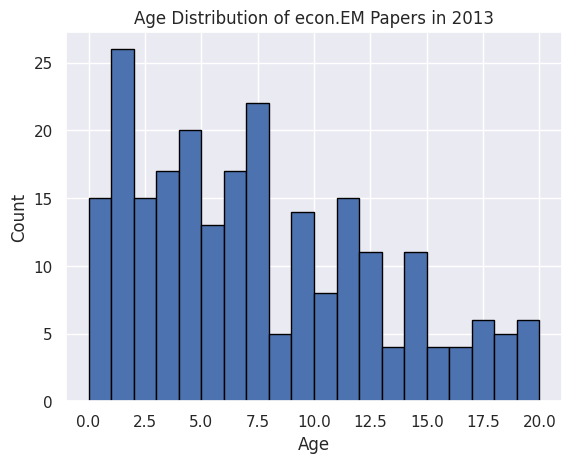

In [ ]:
# To plot the numbers of reference papers vs their age(in years) for a particular year.

# Flatten the nested list
ages_list = list(itertools.chain(*total_ages))
filter_list = []
for age in ages_list:
  if age<=20:
    filter_list.append(age)
  else:
    pass
ages_list = filter_list

# Determine the minimum and maximum values
min_age = min(ages_list)
if min_age < 0:
  min_age = 0
else:
  min_age = min(ages_list)
max_age = max(ages_list)

# Decide on the number of bins
num_bins = max_age

# Calculate the width of each bin
bin_width = (max_age - min_age) / num_bins
# Initialize a list to store the counts in each bin
bin_counts = [0] * num_bins

# Assign each age to its bin and increment the count
for age in ages_list:
    bin_index = abs(int((age - min_age) // bin_width)-1)
    bin_counts[bin_index] += 1

# Visualize the age distribution
bins = np.arange(min_age, max_age + bin_width, bin_width)
plt.hist(ages_list, bins=bins, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution of econ.EM Papers in 2013')
plt.show()

In [ ]:
sch = SemanticScholar(timeout=100)
def custom_fn(strng = None):
  ct_count = []
  study_field = []
  df = pd.read_csv(strng)
  for i in df.index:
    try:
      paper = sch.get_paper("arxiv:" + basename(df['link'][i]).split("v")[0], fields=['citationCount','fieldsOfStudy'])
      ct_count.append(paper.citationCount)
      study_field.append(paper.fieldsOfStudy)
    except:
      ct_count.append(np.NaN)
      study_field.append(np.NaN)
  df.insert(loc=3, column='Citation Count', value = pd.Series(ct_count))
  df.insert(loc=4, column='Fields of Study', value = pd.Series(study_field))
  df.to_csv(strng.split('.')[0]+str('_new.csv'))

# Write the filename for the csv file generated by the output.
custom_fn('output.csv')